In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext line_profiler

In [3]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_us_sheet = 'US Eco Const'
str_all_sheet = 'All Eco Const'
str_description_sheet = 'Description Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags.xlsx'
str_flag_sheet = 'All to check'
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.h5'
str_exported_key = 'all_idx_exported'
str_raw_filled_key = 'all_idx_raw_filled'
str_description_key = 'descriptions_exported'
str_flags_key = 'flags_exported'
### HDF file with matrices:
str_path_bb_matrix_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices.h5'
str_raw_history_key = 'raw_history'
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_start = datetime_start.date()
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
### Gaps filling options
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2

In [4]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, parse_dates = True,
                               na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block seperately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float',
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_idx_hdf, key = str_exported_key, mode = 'w')

In [5]:
### RUN TO RE-EXPORT DATA: DESCRIPTION FILE EXPORT

### Readind excel file:
df_description = pd.read_excel(io = str_path_bb_idx_source, sheet_name = str_description_sheet, skiprows = [0], usecols = list(range(10)), index_col = 0, header = 0, 
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_description.dropna(how = 'all', inplace = True)
df_description.index.name = 'Index_Name'
### Types converting:
df_description = df_description.astype({'ID_BB0': int,
                                        'SECURITY_DES': str,
                                        'SHORT_NAME': str,
                                        'FEED_CODE': str,
                                        'INDX_SOURCE': str,
                                        'COUNTRY': str,
                                        'INDX_HIST_START_DT_MONTHLY': str,
                                        'DES_NOTES': str,
                                        'INDX_FREQ': str,                       
                                      })
### Exported dataframe saving:
df_description.to_hdf(str_path_bb_idx_hdf, key = str_description_key, mode = 'a')

In [6]:
### RUN TO RE-EXPORT DATA: REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_idx_hdf, key = str_exported_key)[['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION']]
### Dropping rows with all Index Values missed (96,369 rows left):
#df_all_idx_revisions = \
#        df_all_idx_revisions.loc[df_all_idx_revisions['PX_LAST'].notna() | df_all_idx_revisions['ACTUAL_RELEASE'].notna() | df_all_idx_revisions['FIRST_REVISION'].notna()]
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value']

In [ ]:
### RUN TO TESTING: UNIVERSAL REQUEST CONSTRUCTOR

df_all_idx_revisions[df_all_idx_revisions['Final_Value'].notna() & df_all_idx_revisions['Release_Value'].isna() & df_all_idx_revisions['Revision_Value'].notna()]

In [7]:
### RUN TO RE-EXPORT DATA: MAIN STATS

### General stats:
print('Rows with at least one value filled:', len(df_all_idx_revisions.index))
print('Eco Indices number:', len(df_all_idx_revisions.index.get_level_values(0).unique()))
print('Average data dates number:', int(df_all_idx_revisions.groupby('Index_Name').apply(lambda df_group: len(df_group.index)).mean()))
### Release data analyzing (96,369 rows):
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### Data quantity:
print('Release Info: filled date & value:', len(df_release_based.loc[df_release_based['Observation_Date'].notna() & df_release_based['Index_Value'].notna()]), 'rows')
print('Release Info: empty date & value:', len(df_release_based.loc[df_release_based['Observation_Date'].isna() & df_release_based['Index_Value'].isna()]), 'rows')
print('Release Info: empty date & filled value:', len(df_release_based.loc[df_release_based['Observation_Date'].isna() & df_release_based['Index_Value'].notna()]), 'rows')
print('Release Info: filled date & empty value:', len(df_release_based.loc[df_release_based['Observation_Date'].notna() & df_release_based['Index_Value'].isna()]), 'rows')
### First revision data analyzing (96,369 rows):
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### Data quantity:
print('First revision Info: filled date & value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].notna() & df_revision_based['Index_Value'].notna()]), 'rows')
print('First revision Info: empty date & value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].isna() & df_revision_based['Index_Value'].isna()]), 'rows')
print('First revision Info: empty date & filled value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].isna() & df_revision_based['Index_Value'].notna()]), 'rows')
print('First revision Info: filled date & empty value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].notna() & df_revision_based['Index_Value'].isna()]), 'rows') 

Rows with at least one value filled: 87422
Eco Indices number: 255
Average data dates number: 342
Release Info: filled date & value: 50964 rows
Release Info: empty date & value: 33774 rows
Release Info: empty date & filled value: 445 rows
Release Info: filled date & empty value: 2239 rows
First revision Info: filled date & value: 15298 rows
First revision Info: empty date & value: 72062 rows
First revision Info: empty date & filled value: 58 rows
First revision Info: filled date & empty value: 4 rows


In [8]:
### RUN TO RE-EXPORT DATA: DETAILED STATS: RELEASE DATE/VALUE PAIR

### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
print('Eco Indices without any release date number:', len(ser_empty_release_date.index))
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
print('Eco Indices without any release value number:', len(ser_empty_release_value.index))
### Empty Eco Indices relese info lists comparision:
print('Symmetric difference of empty release info Eco Indices lists:', list(set(ser_empty_release_date.index).symmetric_difference(set(ser_empty_release_value.index))))
print('Union of empty release info Eco Indices lists:\n', sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index)))))
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
for iter_eco_index in sorted(list(set(ser_empty_release_date.index).symmetric_difference(set(ser_empty_release_value.index)))):
    print('Symmetric difference for', iter_eco_index, ':\n', 
          df_all_idx_revisions.loc[(iter_eco_index, All), All].dropna(subset = ['Release_Date', 'Release_Value'], how = 'all'))

Eco Indices without any release date number: 10
Eco Indices without any release value number: 10
Symmetric difference of empty release info Eco Indices lists: []
Union of empty release info Eco Indices lists:
 ['DTSRR1EB Index', 'ESRSREHY Index', 'EUNOEUM Index', 'FICP00MM Index', 'IEVHNEWY Index', 'JNBTCASE Index', 'JNRSLYYT Index', 'LTSBBCBU Index', 'NHSPAWE1 Index', 'RSSA25M Index']


In [9]:
### RUN TO TESTING: DESCRIPTION OF PX_LAST ONLY ECO INDICES

df_description = pd.read_hdf(str_path_bb_idx_hdf, key = str_description_key)
#df_description.loc[list_empty_release]#.to_excel('Data_Files/Test_Files/PX_LAST_only_indices.xlsx')

In [10]:
### RUN TO RE-EXPORT DATA: DETAILED STATS: FIRST REVISION DATE/VALUE PAIR

### All empty release date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
print('Eco Indices without any revision date number:', len(ser_empty_revision_date.index))
### All empty release value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
print('Eco Indices without any revision value number:', len(ser_empty_revision_value.index))
### Empty Eco Indices relese info lists comparision:
print('Symmetric difference of empty revision info Eco Indices lists:', 
      sorted(list(set(ser_empty_revision_date.index).symmetric_difference(set(ser_empty_revision_value.index)))))
print('Union of empty revision info Eco Indices lists:\n', sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index)))))
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))
for iter_eco_index in sorted(list(set(ser_empty_revision_date.index).symmetric_difference(set(ser_empty_revision_value.index)))):
    print('Symmetric difference for', iter_eco_index, ':\n', 
          df_all_idx_revisions.loc[(iter_eco_index, All), All].dropna(subset = ['Revision_Date', 'Revision_Value'], how = 'all'))

Eco Indices without any revision date number: 73
Eco Indices without any revision value number: 72
Symmetric difference of empty revision info Eco Indices lists: ['MPMIITMA Index']
Union of empty revision info Eco Indices lists:
 ['BAKETOT Index', 'BECCN Index', 'BECPCHNG Index', 'BRCPALLY Index', 'CONSSENT Index', 'DTSRR1EB Index', 'ESCPLMOM Index', 'ESRSREHY Index', 'EUNOEUM Index', 'FICP00MM Index', 'FIPPIR2M Index', 'FIUER Index', 'GKCPIUHY Index', 'GKCPNEWY Index', 'GKUERATE Index', 'GRCP2BRM Index', 'GRCP2BVM Index', 'GRCP2NRM Index', 'GRCP2SAM Index', 'GRZECURR Index', 'GRZEEUEX Index', 'GRZEWI Index', 'IECPEUIQ Index', 'IECPIMOM Index', 'IECSINDX Index', 'IEVHNEWY Index', 'ITSR1B Index', 'JCOMHCF Index', 'JNBTCASE Index', 'JNCAP Index', 'JNCVSSY Index', 'JNDSNYOY Index', 'JNDSTYOY Index', 'JNRSLYYT Index', 'JNSMTYOY Index', 'JNVHSYOY Index', 'JWCOOVRL Index', 'JWEXOVRL Index', 'KPRSLFLS Index', 'LTSBBCBU Index', 'MPMIDEMA Index', 'MPMIDESA Index', 'MPMIEZCA Index', 'MPMIEZMA In

In [11]:
### RUN TO RE-EXPORT DATA: DATA CLEARING

### MPMIITMA Index Revision_Value mistake correctio:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN

In [12]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_description = pd.read_hdf(str_path_bb_idx_hdf, key = str_description_key)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_description.loc[str_index_name, 'INDX_FREQ']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        int_first_release_idx = df_eco_ind.index.get_loc(idx_first_valid_release)
        df_first_released = df_eco_ind.iloc[int_first_release_idx : int_first_release_idx + int_first_mean_length]
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        int_first_release_idx = df_eco_ind.index.get_loc(idx_first_valid_release)
        df_first_released = df_eco_ind.iloc[int_first_release_idx : int_first_release_idx + int_first_mean_length]
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling revision dates lag before the first known revision date: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value']]

### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)
### Dataframe types control:
print(df_dates_filled.dtypes)
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_idx_hdf, key = str_raw_filled_key, mode = 'a')

Release_Date      datetime64[ns]
Release_Value            float64
Revision_Date     datetime64[ns]
Revision_Value           float64
Final_Date        datetime64[ns]
Final_Value              float64
dtype: object


In [125]:
### RUN TO TESTING: DATE FILLING RESULTS

### "Usual" eco index: 'SPRSRAY Index'
### No first revision eco index: 'BAKETOT Index'
### No release eco index: 'DTSRR1EB Index'

df_eco_ind = df_dates_filled.loc[('SPRSRAY Index', All), All]
df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value']].to_excel('Data_Files/Test_Files/Date_Filler_Testing.xlsx')

In [13]:
### VALUES STACKING

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_raw_filled_key)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Index_Value']
df_release_pair = df_release_pair.dropna(subset = ['Observation_Date'])
df_release_pair['Stage'] = 'Release'
ser_release_based = df_release_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### First revision pair stacking:
df_revision_pair = df_dates_filled[['Revision_Date', 'Revision_Value']]
df_revision_pair.columns = ['Observation_Date', 'Index_Value']
df_revision_pair = df_revision_pair.dropna(subset = ['Observation_Date'])
df_revision_pair['Stage'] = 'First Revision'
ser_revision_based = df_revision_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Final revision pair stacking:
df_final_pair = df_dates_filled[['Final_Date', 'Final_Value']]
df_final_pair.columns = ['Observation_Date', 'Index_Value']
df_final_pair = df_final_pair.dropna(subset = ['Observation_Date'])
df_final_pair['Stage'] = 'Final Revision'
ser_final_based = df_final_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Vectors aggregating:
ser_history_raw = ser_final_based.combine_first(ser_revision_based).combine_first(ser_release_based).dropna().sort_index()
### Results saving:
ser_history_raw.to_hdf(str_path_bb_matrix_hdf, key = str_raw_history_key, mode = 'w')

In [ ]:
### RUN TO TESTING: DATES COMPARING:



In [14]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Readind excel file:
df_flags = pd.read_excel(io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(16)), index_col = 4, header = 0, 
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_idx_hdf, key = str_flags_key, mode = 'a')

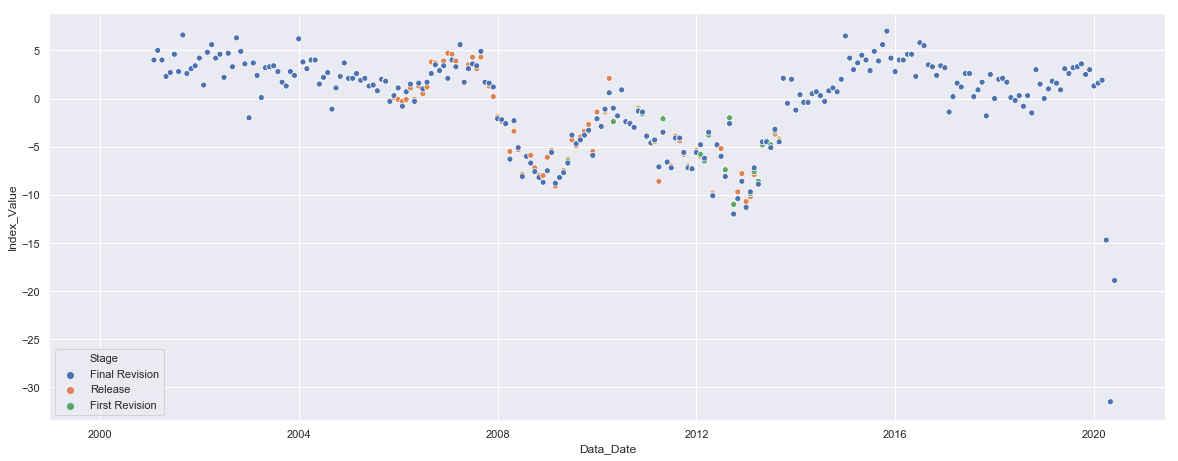

In [6]:
### TEMP

str_test_index = 'SPRSRAY Index'

ser_history_raw = pd.read_hdf(str_path_bb_matrix_hdf, key = str_raw_history_key)

sns.set(rc = {'figure.figsize': (20, 7.5)})
sns.scatterplot(data = ser_history_raw.loc[str_test_index].reset_index(), x = 'Data_Date', y = 'Index_Value', hue = 'Stage')

In [33]:
### TEMP

def test_function():
    def diagonal_reindex(ser_group, date_end):
        date_diag = ser_group.index.get_level_values(1)[0].date()
        idx_date_diag = pd.date_range(date_diag, date_end, freq = 'B')
        ser_result = ser_group.droplevel([0, 1]).reindex(idx_date_diag)
        return ser_result

    ser_reindexed = ser_history.loc['BAKETOT Index', All, All].groupby(['Index_Name', 'Data_Date']).apply(diagonal_reindex, date_end)
    ser_reindexed.index.rename('Observation_Date', level = -1, inplace = True)
    return ser_reindexed

In [34]:
### TEMP

%timeit test_function()

2min 12s ± 595 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
### TEST

ser_reindexed = ser_history.loc['BAKETOT Index', All, All].droplevel(0).unstack('Data_Date').reindex(pd.date_range(date_start, date_end, freq = 'B'))\
                                                                  .stack('Data_Date', dropna = False).squeeze()
ser_reindexed = ser_reindexed.swaplevel().sort_index()
ser_reindexed.index.rename('Observation_Date', level = -1, inplace = True)

In [ ]:
### TEMP

def diagonal_filter(ser_group):
    date_diag = ser_group.index.get_level_values(0)[0]
    ser_result = ser_group.droplevel(0)
    ser_result = ser_result[ser_result.index >= date_diag]
    return ser_result

ser_reindexed.groupby('Data_Date').apply(diagonal_filter)

In [57]:
### TEMP

def diagonal_reindex(ser_name, date_end):
    
    def diagonal_filter(ser_date):
        date_diag = ser_date.index.get_level_values(0)[0]
        ser_result = ser_date.droplevel(0)
        ser_result = ser_result[ser_result.index >= date_diag]
        return ser_result
    
    ser_full = ser_name.droplevel(0).unstack('Data_Date').reindex(pd.date_range(date_start, date_end, freq = 'B')).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel().sort_index()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)
    ser_full.groupby('Data_Date').apply(diagonal_filter)
    
    
ser_reindexed = ser_history.groupby('Index_Name').apply(diagonal_reindex, idx_date_range)

Data_Date   Observation_Date
2002-05-31  1985-01-01         NaN
            1985-01-02         NaN
            1985-01-03         NaN
            1985-01-04         NaN
            1985-01-07         NaN
                                ..
            2020-08-25         NaN
            2020-08-26         NaN
            2020-08-27         NaN
            2020-08-28         NaN
            2020-08-31         NaN
Length: 9305, dtype: float64

In [24]:
### RUN TO RE-EXPORT DATA: EXTERNAL HDF GENERATING

### Local parameters:
str_path_bb_idx_export = 'Data_Files/Source_Files/Bloomberg_Eco_Indices_Export.h5'
str_matrix_export_key = 'matrix_export'
str_flags_export_key = 'flags_export'

ser_history_raw = pd.read_hdf(str_path_bb_matrix_hdf, key = str_raw_history_key)
df_flags_short = pd.read_hdf(str_path_bb_idx_hdf, key = str_flags_key).drop(['Adjustment', 'Demean', 'Sum', 'Negative', 'Index', 'YoY', 'Log',], axis = 1)

ser_history_raw.to_hdf(str_path_bb_idx_export, key = str_matrix_export_key, mode = 'w')
df_flags_short.to_hdf(str_path_bb_idx_export, key = str_flags_export_key, mode = 'a')